In [2]:
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import json
import networkx as nx
import pandas as pd
from ast import literal_eval
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt


In [3]:
def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

In [4]:
G = read_json_file('./data/graph.json')

In [5]:
field_list = []

def remove_node_if_no_field(author):
    try:
        field = G.nodes[author]['top_field']
        if field == 'nan':
            G.remove_node(author)
        else:
            field_list.append(field)
    except KeyError:
        G.remove_node(author)

authors = list(G.nodes)
for a in authors:
    remove_node_if_no_field(a)

In [6]:
n = len(G.nodes)
print(n)

5652


In [7]:
print(G.nodes[83401236]['top_field'])
print(list(G.adj[83401236]))

Geography
[]


In [8]:
def edge_same_top_field(edge, graph):
    field_a = graph.nodes[edge[0]]['top_field']
    field_b = graph.nodes[edge[1]]['top_field']
    return field_a == field_b



In [9]:
top_field_fraq_list = [edge_same_top_field(edge, G) for edge in list(G.edges)]

In [10]:
top_field_fraq = np.mean(top_field_fraq_list)

In [11]:
def randomize_field_get_mean(graph):
    for author, field in zip(list(graph.nodes), np.random.permutation(field_list)):
        graph.nodes[author]['top_field'] = field

    top_field_fraq = [edge_same_top_field(edge, graph) for edge in list(graph.edges)]

    return np.mean(top_field_fraq)

results = []
N_repeat = 500
graph_copy = G.copy()

for i in tqdm(range(N_repeat)):
    results.append(randomize_field_get_mean(graph_copy))

100%|██████████| 500/500 [00:10<00:00, 47.80it/s]


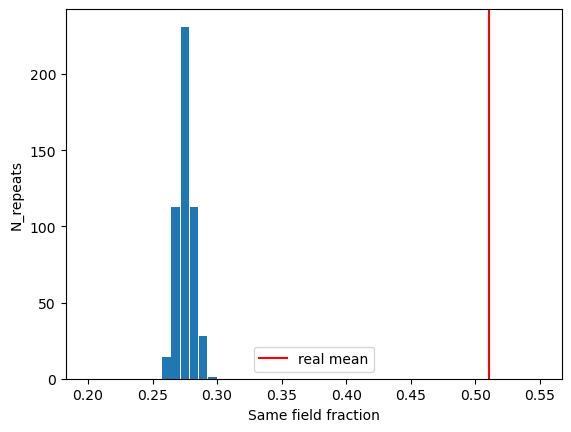

In [12]:
bins = np.linspace(0.2, 0.55, 50)
hist, edges = np.histogram(results, bins=bins)
x = (edges[1:] + edges[:-1])/2
width = bins[1] - bins[0]

fig, axs = plt.subplots()
axs.bar(x, hist, width=width*0.9)

axs.set_xlabel('Same field fraction')
axs.set_ylabel('N_repeats')
axs.axline((top_field_fraq, 0), (top_field_fraq, max(results)), color='red', label='real mean')
axs.legend()

In [13]:
fields_unique = np.unique(field_list)
fields_unique_n = len(fields_unique)

field_index = {}

for i in range(fields_unique_n): # Use this index for matrix
    field_index[fields_unique[i]] = i

degree_max = np.max([t[1] for t in list(G.degree)])
print(degree_max)

field_matrix = np.zeros((fields_unique_n-1, fields_unique_n-1)) # -1 to avoid the nan which is included in fields unique
degree_matrix = np.zeros((44, 44))

for edge in list(G.edges): # For all edges, increment related matrix values

    field_a = G.nodes[edge[0]]['top_field']
    field_b = G.nodes[edge[1]]['top_field']

    deg_a = G.degree[edge[0]]
    deg_b = G.degree[edge[1]]

    degree_matrix[deg_a, deg_b] += 1
    degree_matrix[deg_b, deg_a] += 1

    try:
        field_a_index = field_index[field_a]
        field_b_index = field_index[field_b]

        field_matrix[field_a_index, field_b_index] += 1
        field_matrix[field_b_index, field_a_index] += 1

    except: # Some fields are nan, do nothing
        pass

field_matrix = field_matrix.astype(int)
field_matrix = np.divide(field_matrix, np.sum(field_matrix))

degree_matrix = np.divide(degree_matrix, np.sum(degree_matrix))



43


In [14]:
r_field = (np.trace(field_matrix) - np.sum(field_matrix**2))/(1-np.sum(field_matrix**2))
r_degree = (np.trace(degree_matrix) - np.sum(degree_matrix**2))/(1-np.sum(degree_matrix**2))

In [ ]:
print("assortativity coefficient for field", r_field)

print("assortativity coefficient for degree", r_degree)

print(G.degree[83401236])


In [ ]:
print(fields_unique)
print((field_matrix*100).astype(int))

In [ ]:
from netwulf.interactive import visualize

**Exercise 2**

In [ ]:
G = nx.karate_club_graph()

In [ ]:
club_colors = {'Mr. Hi': '#0000ff', 'Officer': '#ff0000'}

for i in range(len(G.nodes)):
    club = G.nodes[i]['club']
    G.nodes[i]['color'] = club_colors[club]

def modularity(graph, partitioning):
    L_c = defaultdict(lambda: 0)
    L = len(graph.nodes)

    for node in graph.nodes:

        partition = graph.nodes[node][partitioning]
        L_c[partition] += 1

    k = len(graph.edges)
    k_c = defaultdict(lambda: 0)

    for edge in graph.edges:
        partition1 = graph.nodes[edge[0]][partitioning]
        partition2 = graph.nodes[edge[1]][partitioning]
        if partition1 == partition2:
            k_c[partition1] += 1

    M = 0

    for i in range(len(k_c)):
        M += (list(L_c.values())[i]/L) - (list(k_c.values())[i]/(2*L))**2

    return M





Modularity reflects communities within the network structure. A high modularity means a partition is good at separating chunks of nodes that have high interlinkage. This also means that if a network structure is scrambled, the modularity can be greatly affected using the same partition.

Another way of looking at it, is that modularity is high, when few links (edges) need to be broken to create to separate graphs for each partition.

In [ ]:
visualize(G)


In [ ]:
# 4
print(modularity(G, 'club'))

In [ ]:
# 5
G_copy = G.copy()

print(G_copy.edges)

def get_two_edges(graph):
    n_edges = len(graph.edges)
    n = np.random.choice(n_edges, 2)
    edge1 = list(graph.edges)[n[0]]
    edge2 = list(graph.edges)[n[1]]
    return edge1, edge2

def double_edge_swap(graph):
    (u, v), (x, y) = get_two_edges(graph)

    if u == v or v == x:
        return double_edge_swap(graph)

    if not graph.has_edge(u, y):
        return double_edge_swap(graph)

    if not graph.has_edge(x, v):
        return double_edge_swap(graph)

    print("Removing", u, y, "and", x, v, "and adding", u, v, "and", x,y)
    graph.add_edge(u, y)
    graph.add_edge(x, v)

    graph.remove_edge(u, v)
    graph.remove_edge(x, y)

    return graph

def N_swaps(graph, N = 100):
    if N > 0:
        return N_swaps(double_edge_swap(graph), N=N-1)
    else:
        return graph

print(double_edge_swap(G_copy).edges)

G_copy = N_swaps(G_copy, 5)



for u, v in G_copy.edges:
    for x, y in G_copy.edges:
        if u != v and v != x: # b
            edge1_exists = G_copy.has_edge(u, y)
            edge2_exists = G_copy.has_edge(x, v)
            if not edge1_exists and not edge2_exists: # If edges dont exist
                #print(u, v)
                G_copy.add_edge(u, y) # Add them
                G_copy.add_edge(x, v)
                G_copy.remove_edge(u, v) # Remove others
                G_copy.remove_edge(x, y)


In [44]:
club_colors = {'Mr. Hi': '#0000ff', 'Officer': '#ff0000'}

for i in range(len(G.nodes)):
    club = G.nodes[i]['club']
    G.nodes[i]['color'] = club_colors[club]

def modularity(graph, partitioning):
    L_c = defaultdict(lambda: 0)
    L = len(graph.nodes)

    for node in graph.nodes:

        partition = graph.nodes[node][partitioning]
        L_c[partition] += 1

    k = len(graph.edges)
    k_c = defaultdict(lambda: 0)

    for edge in graph.edges:
        partition1 = graph.nodes[edge[0]][partitioning]
        partition2 = graph.nodes[edge[1]][partitioning]
        if partition1 == partition2:
            k_c[partition1] += 1

    M = 0

    for i in range(len(k_c)):
        M += (list(L_c.values())[i]/L) - (list(k_c.values())[i]/(2*L))**2

    return M





0.5136245674740485


Modularity reflects communities within the network structure. A high modularity means a partition is good at separating chunks of nodes that have high interlinkage. This also means that if a network structure is scrambled, the modularity can be greatly affected using the same partition.

Another way of looking at it, is that modularity is high, when few links (edges) need to be broken to create to separate graphs for each partition.

In [37]:
visualize(G)


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 57274)
Traceback (most recent call last):
  File "/Users/philiphelsted/opt/anaconda3/envs/02467CSS/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/philiphelsted/opt/anaconda3/envs/02467CSS/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Users/philiphelsted/opt/anaconda3/envs/02467CSS/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/philiphelsted/opt/anaconda3/envs/02467CSS/lib/python3.10/http/server.py", line 668, in __init__
    super().__init__(*args, **kwargs)
  File "/Users/philiphelsted/opt/anaconda3/envs/02467CSS/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/Users/philiphelsted/opt/anaconda3/envs/

(None, None)

In [46]:
# 4
print(modularity(G, 'club'))

0.5136245674740485


In [67]:
# 5
G_copy = G.copy()

print(G_copy.edges)

def get_two_edges(graph):
    n_edges = len(graph.edges)
    n = np.random.choice(n_edges, 2)
    edge1 = list(graph.edges)[n[0]]
    edge2 = list(graph.edges)[n[1]]
    return edge1, edge2

def double_edge_swap(graph):
    (u, v), (x, y) = get_two_edges(graph)

    if u == v or v == x:
        return double_edge_swap(graph)

    if not graph.has_edge(u, y):
        return double_edge_swap(graph)

    if not graph.has_edge(x, v):
        return double_edge_swap(graph)

    print("Removing", u, y, "and", x, v, "and adding", u, v, "and", x,y)
    graph.add_edge(u, y)
    graph.add_edge(x, v)

    graph.remove_edge(u, v)
    graph.remove_edge(x, y)

    return graph

def N_swaps(graph, N = 100):
    if N > 0:
        return N_swaps(double_edge_swap(graph), N=N-1)
    else:
        return graph

print(double_edge_swap(G_copy).edges)

G_copy = N_swaps(G_copy, 5)



for u, v in G_copy.edges:
    for x, y in G_copy.edges:
        if u != v and v != x: # b
            edge1_exists = G_copy.has_edge(u, y)
            edge2_exists = G_copy.has_edge(x, v)
            if not edge1_exists and not edge2_exists: # If edges dont exist
                #print(u, v)
                G_copy.add_edge(u, y) # Add them
                G_copy.add_edge(x, v)
                G_copy.remove_edge(u, v) # Remove others
                G_copy.remove_edge(x, y)


[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 7), (3, 12), (3, 13), (4, 6), (4, 10), (5, 6), (5, 10), (5, 16), (6, 16), (8, 30), (8, 32), (8, 33), (9, 33), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (18, 32), (18, 33), (19, 33), (20, 32), (20, 33), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 31), (26, 29), (26, 33), (27, 33), (28, 31), (28, 33), (29, 32), (29, 33), (30, 32), (30, 33), (31, 32), (31, 33), (32, 33)]
Removing 31 32 and 31 33 and adding 31 33 and 31 32
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 3), (2, 7), (2, 8), 

TypeError: double_edge_swap() takes 1 positional argument but 2 were given